In [1]:
%%capture

import numpy as np
import pyvista as pv
import ot
import torch
from sklearn import datasets
from REW_utils import *
import matplotlib.pyplot as plt
from IPython.display import SVG

# Introduction of Relaxed Embedded Wasserstein

Our relaxed embedded Wasserstein algorithm enables the joint embedding of two different metric spaces $(X_i, d_i)$, $i=1,2$, both equipped with some probability measure, into a joint metric space $(Z, d_Z)$. This is particularly interesting for joint dimensionality reduction. Input metric spaces can be arbitrary. In this first example, we look at two manifolds that are (almost) isometric to an Euclidean rectangle, namely an s-curve and a Swiss roll. Here, the distances are the geodesic (or 'shortest-path') distances. Our reference space $(Z, d_Z)$ is some Euclidean rectangle.

## Create of Rolls as Geodesic Metric Spaces

In [2]:
def roll_to_mesh(P,c,alpha):
    cloud_2d = pv.PolyData(np.array([P[:,1],c,[1]*len(c)]).T)
    vol = cloud_2d.delaunay_2d(alpha=alpha)
    shell = vol.extract_geometry()
    pvX = pv.make_tri_mesh(points = P,faces=shell.faces.reshape((-1, 4))[:,1:])
    return pvX

#Create S Roll and Swiss Roll Pointclouds
n_samples = 2000 #number of samples

#load from sklearn
P1,P1c = datasets.make_s_curve(n_samples=n_samples, random_state=0)
P2,P2c = datasets.make_swiss_roll(n_samples=n_samples, random_state=0, hole=True)

#normalize
P1 -= np.mean(P1,axis=0)
P1 /= np.max(ot.dist(P1,metric="euclidean"))
P2 -= np.mean(P2,axis=0)
P2 /= np.max(ot.dist(P2,metric="euclidean"))

#to pyvista_mesh
pvX1 = roll_to_mesh(P1,P1c,0.115)
pvX2 = roll_to_mesh(P2,P2c,0.115)

In [3]:
pl = pv.Plotter(window_size=(300,300))
pl.add_mesh(pvX1)
pl.save_graphic("img_roll/Roll1_org.svg")
# SVG("img_roll/Roll1_org.svg")

In [4]:
pl = pv.Plotter(window_size=(300,300))
pl.add_mesh(pvX2)
pl.save_graphic("img_roll/Roll2_org.svg")
# SVG("img_roll/Roll2_org.svg")

## Define them as Metric Spaces

In [10]:
#convert to gm-space
X1 = GM(X=pvX1.points,Tris=pvX1.faces.reshape((-1, 4))[:,1:],mode="surface",gauge_mode="djikstra",normalize_gauge=True,squared=False)
X2 = GM(X=pvX2.points,Tris=pvX2.faces.reshape((-1, 4))[:,1:],mode="surface",gauge_mode="djikstra",normalize_gauge=True,squared=False)

## Define Reference Space ($Z$, $d_Z$) as grid on $[0, 1.3]^2$ with the Euclidean distance

In [11]:
#fix hyperparameters
n_its = 40 # Iteration of Algorithm
lambda_GW = 5e1 # GW regularization
eps = 6e-4 # Entropic Regularization
box_len = 1.3

#fix support of Z
nx,ny = 30, 30 # Resolution of grid
Z = img2atomic(np.ones((nx,ny)))[0] # Reference space is 2d Euclidean Grid
Z /= np.linalg.norm([nx-1,ny-1]) / np.sqrt(2*box_len)

## Run Joint Embedding

In [12]:
gamma_X1Y1,gamma_Y2X2,zeta1,zeta2 = REW(X1,X2,Z,n_its = n_its,lambda_GW = lambda_GW,eps = eps)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [03:29<00:00,  5.23s/it]


## Visualize Joint Embedding

In [13]:
#threshold small points for visualization later 
thres = 1e-5

Z1m = Z[zeta1 > thres]
Z2m = Z[zeta2 > thres]
zeta1m = zeta1[zeta1 > thres]
zeta2m = zeta2[zeta2 > thres]

In [14]:
s = 3000  # scale for scatter plots
fontsize = 18
c = "black" # color

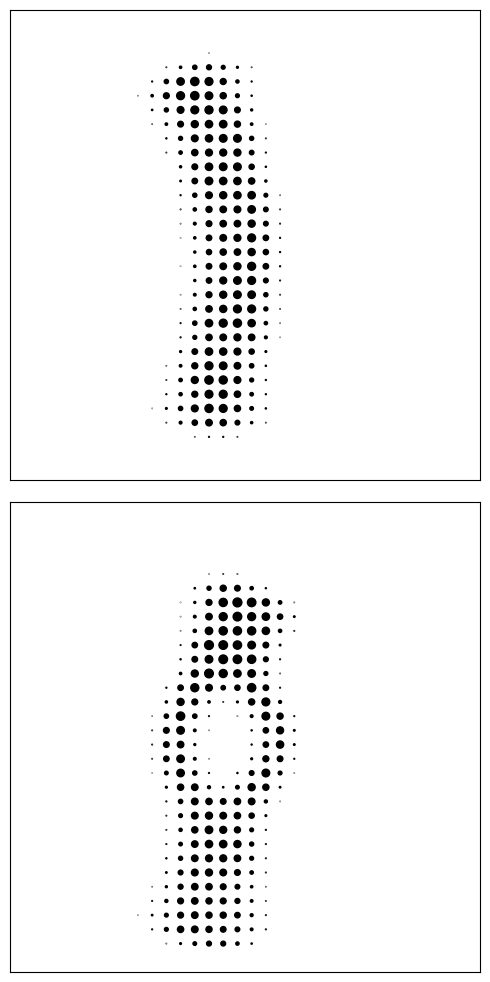

In [15]:
fig,ax = plt.subplots(2,1,figsize=(5,10),sharex=True,sharey=True)
ax[0].set_xlim(0,box_len)
ax[0].set_ylim(0,box_len)

ax[0].scatter(Z1m[:,0],Z1m[:,1],s=s*zeta1m, c=c)
ax[1].scatter(Z2m[:,0],Z2m[:,1], s=s*zeta2m, c=c)

for ax_sub in ax:
    ax_sub.set_xticks([])
    ax_sub.set_yticks([])
    ax_sub.set_aspect('equal')
plt.tight_layout()